In [1]:
import re
import nltk
from nltk.corpus import stopwords
import pandas as pd

from sklearn import cluster
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

In [37]:
STOPWORDS = list(set(stopwords.words('italian')))

In [38]:
to_remove = ["junior", "senior", "stage", "sr", "entwickler", "time", "remote"]
STOPWORDS.extend(to_remove)

In [39]:
def sanitize_text(text: str, remove_stopwords: bool) -> str:
    """This utility function sanitizes a string by:
    - removing links
    - removing special characters
    - removing numbers
    - removing stopwords
    - transforming in lowercase
    - removing excessive whitespaces

    Args:
        text (str): the input text you want to clean
        remove_stopwords (bool): whether or not to remove stopwords

    Returns:
        str: the cleaned text
    """

    # remove links
    text = re.sub(r"http\S+", "", text)
    # remove special chars and numbers
    text = re.sub("[^A-Za-z]+", " ", text)
    # remove stopwords
    if remove_stopwords:
        # 1. tokenize
        tokens = nltk.word_tokenize(text)
        # 2. check if stopword
        tokens = [w for w in tokens if not w.lower() in STOPWORDS]
        # 3. join back together
        text = " ".join(tokens)
    # return text in lower case and stripped of whitespaces
    text = text.lower().strip()
    return text

In [40]:
with open("./jobs.txt", "r", encoding="utf-8") as f:
    jobs = f.read().splitlines()

In [41]:
def normalize_role(text):
    roles_to_normalize = [("front end", "frontend"), ("back end", "backend")]
    for wrong, right in roles_to_normalize:
        if wrong in text:
            return right + " " + text[len(wrong) + 1:]
        else:
            return text

In [42]:
kws = pd.read_excel("kwset.xlsx")
kws = list(kws.keyword)

In [47]:
cleaned_jobs = [sanitize_text(job, remove_stopwords=True) for job in jobs]
cleaned_roles = [normalize_role(job) for job in cleaned_jobs]

In [48]:
def find_number_of_clusters(data, centers):
    # A list holds the silhouette coefficients for each k
    silhouette_coefficients = []

    # Notice you start at 2 clusters for silhouette coefficient
    for k in range(2, 20):
        score = silhouette_score(data, centers)
        silhouette_coefficients.append(score)
    
    return silhouette_coefficients.index(max(silhouette_coefficients))

In [49]:
def find_elbow(X):
    range_n_clusters = range(2, 20)         # clusters range you want to select
    best_clusters = 0                       # best cluster number which you will get
    previous_silh_avg = 0.0

    for n_clusters in tqdm(range_n_clusters, desc="Finding clusters..."):
        clusterer = cluster.KMeans(n_clusters=n_clusters)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        if silhouette_avg > previous_silh_avg:
            previous_silh_avg = silhouette_avg
            best_clusters = n_clusters
    return best_clusters

(1641, 50)


Finding clusters...: 100%|██████████| 18/18 [00:01<00:00, 14.72it/s]


Found number of optimal clusters: 19


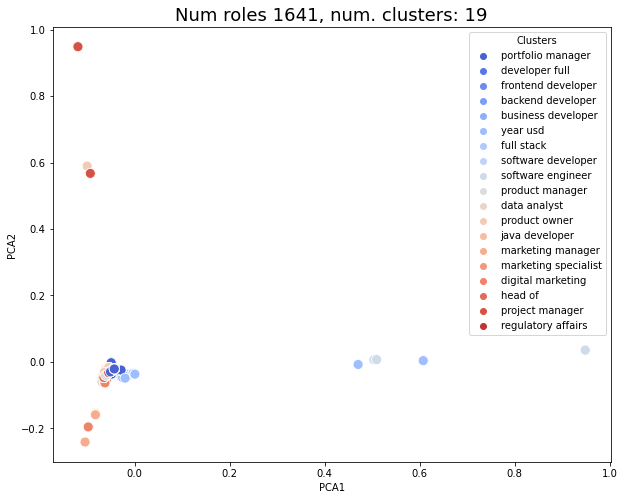

In [52]:
def run(vectorizer, cleaned_jobs):
    X = vectorizer.fit_transform(cleaned_jobs).toarray()
    print(X.shape)
    voc = vectorizer.get_feature_names()

    opt_n_clusters = find_elbow(X)
    print(f"Found number of optimal clusters: {opt_n_clusters}")

    clusterer = cluster.KMeans(n_clusters=opt_n_clusters, random_state=42).fit(X)
    clusters = clusterer.predict(X)

    decomposer = decomposition.PCA(n_components=2, random_state=42)
    reduced = decomposer.fit_transform(X)

    centers = decomposer.transform(clusterer.cluster_centers_)

    component_1, component_2 = reduced[:, 0], reduced[:, 1]
    df = pd.concat([pd.Series(component_1, name="PCA1"), \
        pd.Series(component_2, name="PCA2"), \
            pd.Series(clusters, name="cluster")], axis=1)

    
    # print("Top terms per cluster:")
    order_centroids = clusterer.cluster_centers_.argsort()[:, ::-1]
    kws = []
    for i, (_x, _y) in enumerate(centers):
        # print("Cluster %d:" % i),
        for ind in order_centroids[i, :1]:
            # print(' %s' % voc[ind])
            kws.append(voc[ind])
            # plt.text(_x, _y, f"{i}_{voc[ind]}", horizontalalignment='left', size='medium', color='black')
    
    df['cluster'] = df['cluster'].map({key:value for (key, value) in enumerate(kws)})
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=df, x="PCA1", y="PCA2", hue="cluster", palette="coolwarm", s=100)
    plt.title(f"Num roles {len(cleaned_roles)}, num. clusters: {opt_n_clusters}", fontsize=18)
    plt.legend(fontsize=10, title="Clusters")
    plt.show()

    df['input'] = cleaned_roles

    return df

df = run(TfidfVectorizer(ngram_range=(2, 2), max_features=50, smooth_idf=True, sublinear_tf=True), cleaned_roles)

In [53]:
df

,PCA1,PCA2,cluster,input
0,-0.042981,-0.021206,portfolio manager,django developer w m d
1,-0.042981,-0.021206,portfolio manager,bi developer
2,-0.042981,-0.021206,portfolio manager,mes recipe developer
3,-0.042981,-0.021206,portfolio manager,python developer
4,-0.059776,-0.039170,developer full,drupal developer full
...,...,...,...,...
1636,-0.042981,-0.021206,portfolio manager,communication manager m f d
1637,-0.042981,-0.021206,portfolio manager,client manager turkey international wealth man...
1638,-0.042981,-0.021206,portfolio manager,assistant manager manager genders assurance se...
1639,-0.042981,-0.021206,portfolio manager,procurement manager plastic packaging europe


In [11]:
# todo: remove "full time" and other temporal indicators
# find ideal number of clusters automatically 
# todo: do gridsearch, try these metrics:
#@ https://stackoverflow.com/questions/44066264/how-to-choose-parameters-in-tfidfvectorizer-in-sklearn-during-unsupervised-clust
# Calinski-Harabasz Index
# Davies-Bouldin Index
# https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation

In [12]:
df.to_csv("test.csv", encoding="utf-8", index=False)